In [1]:
# `pandas` for data loading/transformations
import pandas as pd

# `seaborn` for visualization
import seaborn as sns

# `matplotlib` for detailed visualization support
import matplotlib.pyplot as plt
%matplotlib inline

# `numpy` for manipulating arrays/lists
import numpy as np

In [2]:
# # UNCOMMENT BELOW TO USE WITH GOOGLE COLAB
# # Import PyDrive and associated libraries.
# # This only needs to be done once per notebook.
# # Documentation found here: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [3]:
# # UNCOMMENT BELOW TO USE WITH GOOGLE COLAB
# # Link to data file stored in Drive: https://drive.google.com/file/d/18ut1gQQ65aoQeV0iUQlneNhecpGR51dz/view?usp=sharing
# file_id = '18ut1gQQ65aoQeV0iUQlneNhecpGR51dz' # notice where this string comes from in link above

# imported_file = drive.CreateFile({'id': file_id}) # creating an accessible copy of the shared data file
# print(imported_file['title'])  # it should print the title of desired file
# imported_file.GetContentFile(imported_file['title']) # refer to it in this notebook by the same name as it has in Drive

In [4]:
# load our data
ppp_data = pd.read_csv('../datasets/public_150k_plus_borrower_fingerprint_a.csv')

In [5]:
# convert the `DateApproved` column to an actual datetime data type
ppp_data['DateApproved'] = pd.to_datetime(ppp_data['DateApproved'])

# create a variable to hold the second-round start date
second_round_start = pd.to_datetime('2021-01-13')

# treat today's date to use as the "upper" limit on possible second-round loans
todays_date = pd.to_datetime('today')

# use 1/1/2020 as a "lower" limit, since it's before the PPP launched
program_start = pd.to_datetime('2020-01-01')

In [6]:
# pass our boundaries and category labels to the pandas `cut()` function
loan_round = pd.cut(ppp_data.DateApproved,
 bins=[program_start,second_round_start, todays_date],
 labels=['first_round', 'maybe_second'])

# insert the new column at the position we specify
ppp_data.insert(2,'Loan Round',loan_round)

In [7]:
# this "pivot table" will return a Series showing the number
# of times a particular 'BorrowerNameFingerprint' appears in the dataset
loan_count = ppp_data.pivot_table(index=['BorrowerNameFingerprint'],
 aggfunc='size')

# convert our Series to a DataFrame and give it a name
loan_count_df = loan_count.to_frame('Loan Count')

# use the `describe()` method to print out summary statistics
print("Description of duplicate borrower table:")
print(loan_count_df.describe())

Description of duplicate borrower table:
          Loan Count
count  694279.000000
mean        1.104022
std         0.306489
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000


In [8]:
# start by sorting our DataFrame of loan counts from greatest to least
sorted_loan_counts = loan_count_df.sort_values(by=['Loan Count'],
 ascending=False)

# create a new DataFrame with *only* those that have more than two loans
more_than_two = sorted_loan_counts[sorted_loan_counts['Loan Count'] > 2]

# print one instance of each business name that appears in `more_than_two`
print("Businesses that seem to have gotten more than 2 loans:")
print(more_than_two.shape)
print("Number of businesses that appear to have gotten precisely 2 loans:")
precisely_two = sorted_loan_counts[sorted_loan_counts['Loan Count'] == 2]
print(precisely_two.shape)

Businesses that seem to have gotten more than 2 loans:
(58, 1)
Number of businesses that appear to have gotten precisely 2 loans:
(72060, 1)


In [9]:
# use `ProcessingMethod` value to identify second-round loans
pps_loans = ppp_data[ppp_data['ProcessingMethod'] == 'PPS']

# print out the `shape` of this DataFrame to see how many businesses we have
print("Number of loans labeled as second round:")
print(pps_loans.shape)

Number of loans labeled as second round:
(103949, 52)


In [10]:
# how many loans in our derived data frame were approved for precisely $2M
# during the (possibly) second-round timeframe?
# merge our `loan_count_df` back to keep track of businesses
# we labeled as having precisely two loans
ppp_data_w_lc = pd.merge(ppp_data, loan_count_df,
 on=['BorrowerNameFingerprint'], how='left')

# now get *all* the records of business names we associated with two loans
matched_two_loans = ppp_data_w_lc[(ppp_data_w_lc['Loan Count'] == 2)]

# select those loans our `maybe_second` loans that have a value of $2M
maybe_round2_2M = matched_two_loans[
 (matched_two_loans['CurrentApprovalAmount'] == 2000000.00) &
 (matched_two_loans['Loan Round'] == 'maybe_second')]
print("Derived $2M second-round loans:")
print(maybe_round2_2M.shape)

# select those loans that we *know* are second round and have a value of $2M
pps_got_2M = pps_loans[pps_loans['CurrentApprovalAmount'] == 2000000.00]
print("Actual $2M second-round loans:")
print(pps_got_2M.shape)

Derived $2M second-round loans:
(1175, 53)
Actual $2M second-round loans:
(1459, 52)


In [11]:
# isolate the fingerprints of businesses that got $2M second-round loans approved
biz_names = pd.unique(pps_got_2M['BorrowerNameFingerprint'])

# convert that list to a DataFrame
biz_names_df = pd.DataFrame(biz_names, columns=['BorrowerNameFingerprint'])

# create a new array of the same length as our biz_names_df and fill with
# a flag value
fill_column = np.full((len(biz_names),1), '2Mil2ndRnd')
biz_names_df['GotSecond'] = fill_column

# now merge this new, two-column DataFrame back onto our full_data list,
# so that we (hopefully) find their first-round loans as well
second_round_max = pd.merge(ppp_data_w_lc, biz_names_df,
 on='BorrowerNameFingerprint')

In [12]:
# now all the loans that share fingerprints with the ones that got the max
# amount in the second round should have the flag value '2Mil2ndRnd' in the
# 'GotSecond' column
second_max_all_loans = second_round_max[
 second_round_max['GotSecond'] == '2Mil2ndRnd']

# we expect this to be twice the number of businesses that received $2M
# second-round loans
print('Total # of loans approved for most orgs that got $2M for second round:')
print(second_max_all_loans.shape)

Total # of loans approved for most orgs that got $2M for second round:
(2634, 54)


In [13]:
# how much money were these businesses approved to get from the PPP, total?
total_funds = second_max_all_loans['CurrentApprovalAmount'].sum()
print("Total funds approved for identified orgs that could have " + \
 "second-round max:")
print(total_funds)

Total funds approved for identified orgs that could have second-round max:
6250357574.440001


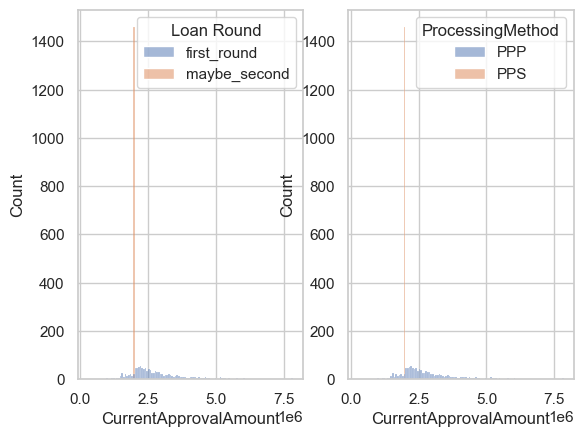

In [14]:
# plot our date-based `Loan Round`-labeled data next to records
# separated by `ProcessingMethod`. Do we get the same results?
# set the seaborn theme
sns.set_theme(style="whitegrid")

# use `matplotlib` `subplots()` to plot charts next to each other
# use `tuples` to access the different subplots later
fig, ((row1col1, row1col2)) = plt.subplots(nrows=1, ncols=2)

# plot the histogram of our date-based analysis
date_based = sns.histplot(data=second_max_all_loans, x='CurrentApprovalAmount',
 hue='Loan Round', ax=row1col1)

# plot the histogram of our data-based analysis
data_based = sns.histplot(data=second_max_all_loans, x='CurrentApprovalAmount',
 hue='ProcessingMethod', ax=row1col2)

# show the plot!
plt.show()